# QA of the risk and impact calculation for unsustainable water consumption:

Generate calculation of the water risk and impact calculations for the unsustainable water consumtion to check discrepancies.

water impacts are deffined as:

    Water impact  (m3 / year ) = (water footprint (m3/year) / production (tons)) * (production (tons) / Total Production (tons)) * Volume (tons)

    Water impact (m3 / year) = Water use per ton * distribution of crop production * tons

Equal to:
    
    Water impact  (m3 / year ) = water footprint (m3/year) * Volume (tons) / Total Production (tons)

    Water impact (m3 / year) = Water use due to the crop * percent of production you are responsible for
    
# Setup
## Library import

In [3]:
# import libraries
import numpy as np
import xarray as xr
import rioxarray as rxr
from xrspatial.classify import natural_breaks
import geopandas as gpd
import cartopy.crs as ccrs

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors

## Utils

In [4]:
def da_plot(da, gdf, color_list, values, title, x='x', y='y', xlim=(65,100), ylim=(4,40)):
    # Define the colors you want
    cmap = ListedColormap(color_list)

    # Define a normalization from values -> colors
    norm = colors.BoundaryNorm(values, len(color_list))

    plt.figure(figsize=(12,10))
    ax = plt.axes(projection=ccrs.PlateCarree())

    ax.set_global()

    da.plot(ax=ax, norm=norm, cmap=cmap, x=x, y=y, transform=ccrs.PlateCarree())
    gdf.plot(ax=ax, color='red', alpha=.1, edgecolor='red')
    ax.coastlines()
    ax.set_xlim((65,100))
    ax.set_ylim((4,40))
    ax.set_title(title)

# Data import
## Vector data 
**India**

In [5]:
#define path
path = '../../datasets/raw/water/QA/'

In [6]:
#import geometry:
geom = gpd.read_file(path+'gadm36_IND_0.shp')
geom.head()

,GID_0,NAME_0,geometry
0,IND,India,"MULTIPOLYGON (((93.78773 6.85264, 93.78849 6.8..."


## Raster data

**Water footprint**

In [7]:
xda = rxr.open_rasterio(path+'/bl_wf_mmyr_area.tif').squeeze().drop("band")
# convert to Dataset 
xds_wf = xr.Dataset({'water_footprint': xda}, attrs=xda.attrs)
xds_wf

<xarray.Dataset>
Dimensions:          (x: 4320, y: 1668)
Coordinates:
  * x                (x) float64 -179.9 -179.9 -179.8 ... 179.8 179.9 180.0
  * y                (y) float64 83.05 82.96 82.88 82.8 ... -55.7 -55.79 -55.87
    spatial_ref      int64 0
Data variables:
    water_footprint  (y, x) float32 ...
Attributes:
    _FillValue:    0.0
    scale_factor:  1.0
    add_offset:    0.0

In [8]:
xds_wf['water_footprint'].quantile([0, 0.25, 0.5, 0.75, 0.5, 1]).values

array([0.00000000e+00, 2.48003438e+05, 2.35365875e+06, 3.86843440e+07,
       2.35365875e+06, 2.61776474e+11])

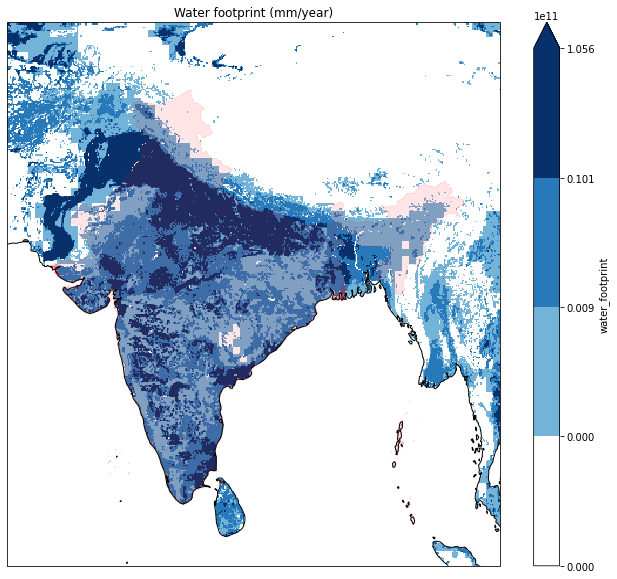

In [9]:
color_list = ["#ffffff", "#73b3d8", "#2879b9", "#08306b"]
values = [0, 29584100, 863202440, 10063202440,  105581714153]
title = 'Water footprint (mm/year)'

da_plot(xds_wf['water_footprint'], geom, color_list, values, title, x='x', y='y', xlim=(65,100), ylim=(4,40))

**Cotto production**

In [10]:
xda = rxr.open_rasterio(path+'/cotton/cotton_Production.tif').squeeze().drop("band")
# convert to Dataset 
xds_cp = xr.Dataset({'cotton_production': xda}, attrs=xda.attrs)
xds_cp

<xarray.Dataset>
Dimensions:            (x: 4320, y: 2160)
Coordinates:
  * x                  (x) float64 -180.0 -179.9 -179.8 ... 179.8 179.9 180.0
  * y                  (y) float64 89.96 89.87 89.79 ... -89.79 -89.88 -89.96
    spatial_ref        int64 0
Data variables:
    cotton_production  (y, x) float32 ...
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

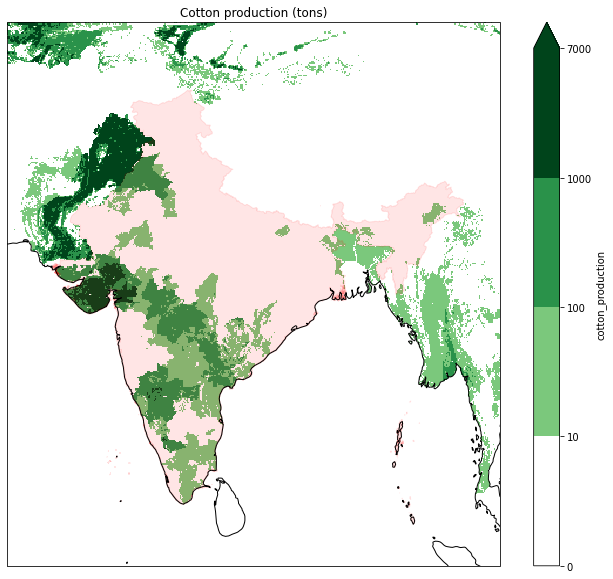

In [11]:
color_list = ["#ffffff", "#7bc87c", "#2a924a", "#00441b"]
values = [0, 10, 100, 1000, 7000]
title = 'Cotton production (tons)'

da_plot(xds_cp['cotton_production'], geom, color_list, values, title, x='x', y='y', xlim=(65,100), ylim=(4,40))

**Cotto harvested area**

In [12]:
xda = rxr.open_rasterio(path+'/cotton/cotton_HarvestedAreaHectares.tif').squeeze().drop("band")
# convert to Dataset 
xds_cha = xr.Dataset({'cotton_harvested_area': xda}, attrs=xda.attrs)
xds_cha

<xarray.Dataset>
Dimensions:                (x: 4320, y: 2160)
Coordinates:
  * x                      (x) float64 -180.0 -179.9 -179.8 ... 179.9 180.0
  * y                      (y) float64 89.96 89.87 89.79 ... -89.88 -89.96
    spatial_ref            int64 0
Data variables:
    cotton_harvested_area  (y, x) float32 ...
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

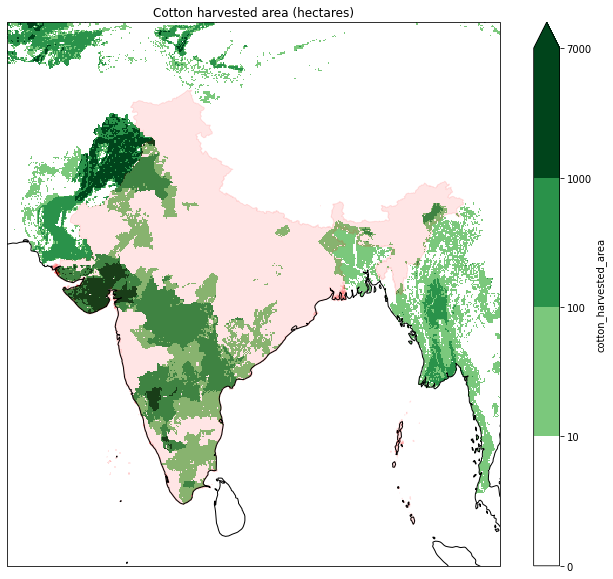

In [13]:
color_list = ["#ffffff", "#7bc87c", "#2a924a", "#00441b"]
values = [0, 10, 100, 1000, 7000]
title = 'Cotton harvested area (hectares)'

da_plot(xds_cha['cotton_harvested_area'], geom, color_list, values, title, x='x', y='y', xlim=(65,100), ylim=(4,40))

#### Merge datasets 
**Equal extents and coordinates**

In [14]:
print("Water footprint bbox: ", xds_wf.rio.bounds())

Water footprint bbox:  (-179.99166664999998, -55.91166665, 180.00836215000007, 83.08834447000001)


In [15]:
variables = {"cotton_production": "cotton_Production",
"cotton_harvested_area": "cotton_HarvestedAreaHectares"}

xds = xds_wf.copy()

for variable, file_name in variables.items():
    # Clip raster by extent:
    !gdal_translate -projwin -179.99166664999998 83.08834447000001 180.00836215000007 -55.91166665 -of GTiff $path"cotton/{file_name}.tif" $path"cotton/{file_name}_wf_box.tif"

    # Create dataset
    xda = rxr.open_rasterio(path+f'/cotton/{file_name}_wf_box.tif').squeeze().drop("band")
    # convert to Dataset 
    xds_tmp = xr.Dataset({variable: xda}, attrs=xda.attrs)

    # Assign water footprint coords
    xds_tmp = xds_tmp.assign_coords(x=xds_wf.x.values)
    xds_tmp = xds_tmp.assign_coords(y=xds_wf.y.values)

    # Add variable to water footprint dataset
    xds[variable] = xds_tmp[variable]

xds 

Input file size is 4320, 2160
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 4320, 2160
0...10...20...30...40...50...60...70...80...90...100 - done.


<xarray.Dataset>
Dimensions:                (x: 4320, y: 1668)
Coordinates:
  * x                      (x) float64 -179.9 -179.9 -179.8 ... 179.9 180.0
  * y                      (y) float64 83.05 82.96 82.88 ... -55.7 -55.79 -55.87
    spatial_ref            int64 0
Data variables:
    water_footprint        (y, x) float32 nan nan nan nan ... nan nan nan nan
    cotton_production      (y, x) float32 ...
    cotton_harvested_area  (y, x) float32 ...
Attributes:
    _FillValue:    0.0
    scale_factor:  1.0
    add_offset:    0.0

# Compute Water risk:

Water risk  (m3 / year tons) = water footprint (m3/year) / Total Production (tons)

**Total production of cotton**

In [19]:
tot_pro = xds["cotton_production"].sum().data
print(f'Total production of cotton: {tot_pro} tonnes')

Total production of cotton: 51099980.0 tonnes


**Water risk**

Water risk  (m3/year) = (water footprint (m3/year) / Total Production (tons)) * Volume (tons) 

In [21]:
mm_to_m3 = 0.001

xds_risk = xds.where(xds.cotton_production > 0).copy()

xds = xds.assign(water_risk = xds_risk.water_footprint*mm_to_m3/tot_pro)

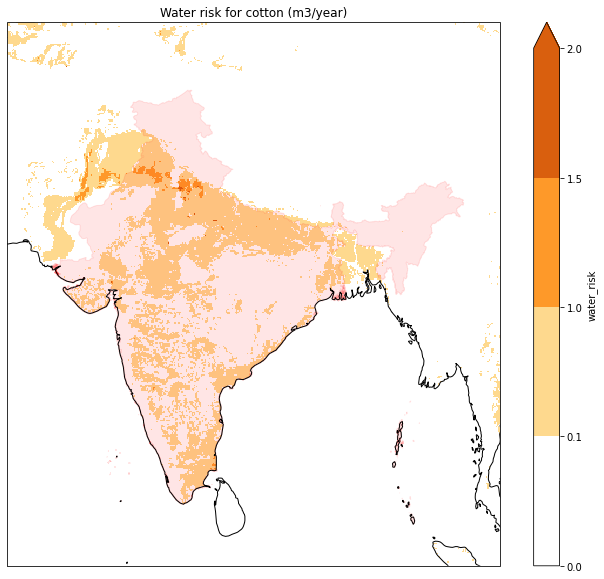

In [23]:
color_list = ["#ffffff", "#fed98e", "#fe9929", "#d95f0e" ]
values = [0,0.1, 1, 1.5, 2]

title = 'Water risk for cotton (m3/year)'

da_plot(xds["water_risk"], geom, color_list, values, title, x='x', y='y', xlim=(65,100), ylim=(4,40))

# Compute Water impact:

Let's say that we have a user that is buying 745 tonnes of cotton in india.

**Clip dataset with India**

In [24]:
xds_ind = xds.rio.clip(geom.geometry, geom.crs, drop=False, invert=False)

In [25]:
xds_ind

<xarray.Dataset>
Dimensions:                (y: 1668, x: 4320)
Coordinates:
  * y                      (y) float64 83.05 82.96 82.88 ... -55.7 -55.79 -55.87
  * x                      (x) float64 -179.9 -179.9 -179.8 ... 179.9 180.0
    spatial_ref            int64 0
Data variables:
    water_footprint        (y, x) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cotton_production      (y, x) float32 nan nan nan nan ... nan nan nan nan
    cotton_harvested_area  (y, x) float32 nan nan nan nan ... nan nan nan nan
    water_risk             (y, x) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    _FillValue:    0.0
    scale_factor:  1.0
    add_offset:    0.0

Text(0.5, 1.0, 'Cotton harvested area in India (hectares)')

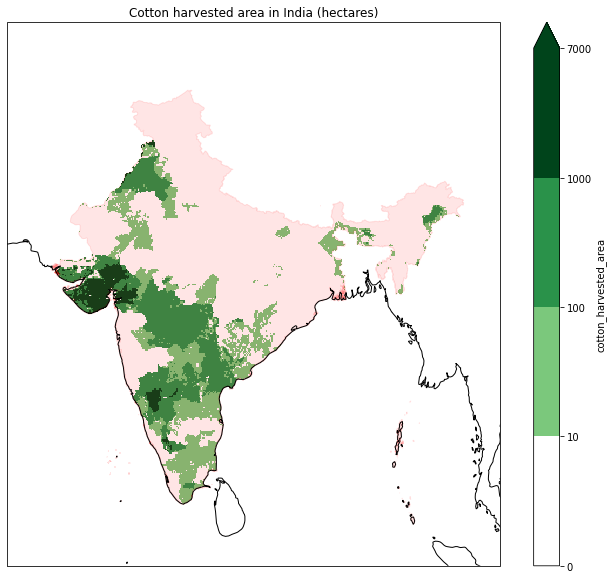

In [26]:
# Define the colors you want
cmap = ListedColormap(["#ffffff", "#7bc87c", "#2a924a", "#00441b"])

# Define a normalization from values -> colors
norm = colors.BoundaryNorm([0, 10, 100, 1000, 7000], 5)

plt.figure(figsize=(12,10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_global()

xds_ind['cotton_harvested_area'].plot(ax=ax, norm=norm, cmap=cmap, x='x', y='y', transform=ccrs.PlateCarree())
geom.plot(ax=ax, color='red', alpha=.1, edgecolor='red')
ax.coastlines()
ax.set_ylim((4,40))
ax.set_xlim((65,100))
ax.set_title('Cotton harvested area in India (hectares)')

**Total harvest area of cotton in India**

In [27]:
tot_ha = xds_ind["cotton_harvested_area"].sum().data
print(f'Total harvest area of cotton in India: {tot_ha} hectares')

Total harvest area of cotton in India: 6977546.0 hectares


### **Evenly distributed volume**

If the volume is distributed evenly across the entire area

Water impact (m3 /year) = Water risk  (m3 / year tons) * Volume(tons) 

In [36]:
volume = 745
mean_risk = xds_ind['water_risk'].mean().data
print(f'Total water impact for cotton in India:: {mean_risk * volume} m3/yr')

Total water impact for cotton in India:: 128.13437595963478 m3/yr


### **Probability purchase area**

The volume is distributed using the 'probabilistics purchase area' approach:

Probability purchase area (tons)  = (Volume(tons) / Total harvest area(ha)) * Harvest area(ha)

Water impact (m3 /year) = Water risk  (m3 / year tons) * Probability purchase area (tons)

In [28]:
xds_ind = xds_ind.assign(probability_purchase_area = (volume/tot_ha)* xds_ind["cotton_harvested_area"])

Text(0.5, 1.0, 'Probability purchase area (tons)')

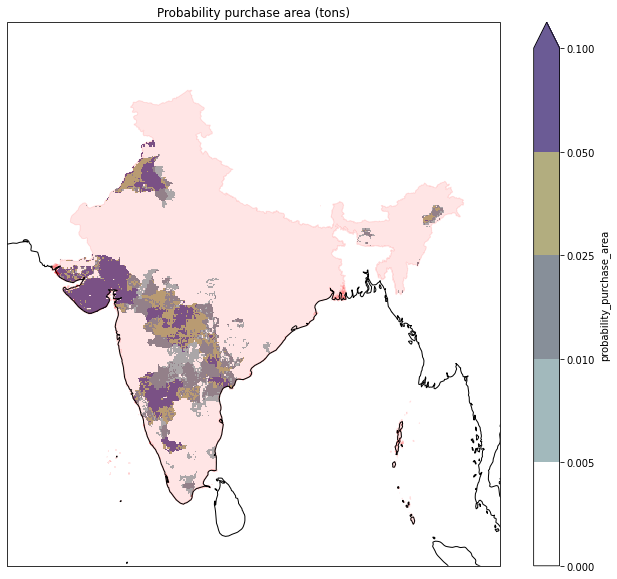

In [29]:
# Define the colors you want
cmap = ListedColormap(["#ffffff", "#a2b9bc", "#878f99", "#b2ad7f", "#6b5b95"])

# Define a normalization from values -> colors
norm = colors.BoundaryNorm([0, 0.005, 0.01, 0.025, 0.05, 0.1], 6)

plt.figure(figsize=(12,10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_global()

xds_ind['probability_purchase_area'].plot(ax=ax, norm=norm, cmap=cmap, x='x', y='y', transform=ccrs.PlateCarree())
geom.plot(ax=ax, color='red', alpha=.1, edgecolor='red')
ax.coastlines()
ax.set_ylim((4,40))
ax.set_xlim((65,100))
ax.set_title('Probability purchase area (tons)')

Check that the volume distributed is equal to the volume injested by the user.

In [30]:
tot_ha = xds_ind["probability_purchase_area"].sum().data
print(f'Total distrivuted volume of cottom in India: {tot_ha} hectares')

Total distrivuted volume of cottom in India: 744.9995727539062 hectares


**Water impact**

Water impact (m3/year) = Water risk (m3/year * tons) * Probability purchase area (tons)

In [34]:
xds_ind = xds_ind.assign(water_impact = xds_ind['water_risk'] * xds_ind['probability_purchase_area'])

Text(0.5, 1.0, 'Distribution of the water impact for 745 tonnes of cotton in India (m3/year')

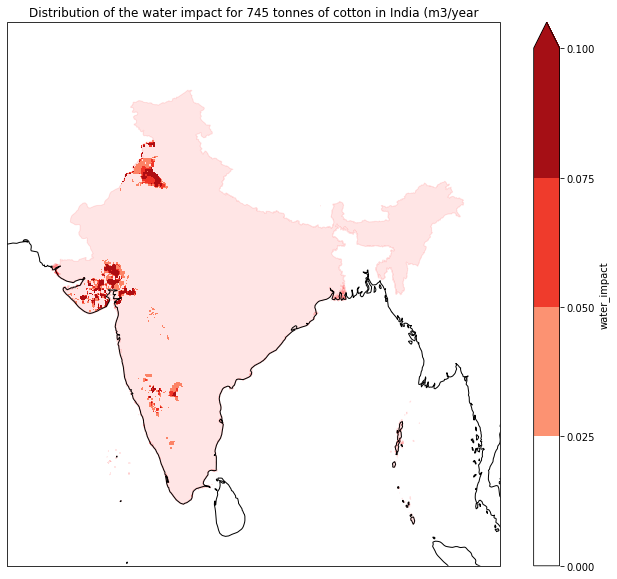

In [33]:
# Define the colors you want
cmap = ListedColormap(["#ffffff", "#fc9272", "#ef3b2c", "#a50f15" ])

# Define a normalization from values -> colors
norm = colors.BoundaryNorm([0,0.025, 0.05, 0.075,  0.1], 5)

plt.figure(figsize=(12,10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_global()

xds_ind['water_impact'].plot(ax=ax, norm=norm, cmap=cmap, x='x', y='y', transform=ccrs.PlateCarree())
geom.plot(ax=ax, color='red', alpha=.1, edgecolor='red')
ax.coastlines()
ax.set_ylim((4,40))
ax.set_xlim((65,100))
ax.set_title('Distribution of the water impact for 745 tonnes of cotton in India (m3/year')

**Total impact for cotton in india**

In [35]:
tot_impact = xds_ind['water_impact'].sum().data
print(f'Total water impact for cotton in India:: {tot_impact} m3/yr')

Total water impact for cotton in India:: 157.9358367919922 m3/yr
